In [38]:
import seaborn as sns
%matplotlib inline
import pylab as pl
import glob

In [39]:
import numpy as np

In [40]:
import pandas as pd

In [41]:
df = pd.read_csv('./data/wspm.txt.tab', sep='\t', index_col=0)

In [42]:
df=df.drop(df.columns[-1], axis=1)

In [43]:
vals=df.values.flatten()
gap=np.mean(vals[vals<0])

In [44]:
def nw(s, t, M, gap_penalty=-2.0):
    s = ['']+s
    t =['']+t
    scores=np.zeros((len(s),len(t)))
    for i in np.arange(0, len(s)):
        scores[i,0]=gap_penalty*i
    for j in np.arange(0, len(t)):
        scores[0,j]=gap_penalty*j
    for i in np.arange(1, len(s)):
        for j in np.arange(1, len(t)):
            mcost = scores[i-1, j-1]+ M[s[i]][t[j]]
            dcost = scores[i-1, j]+ gap_penalty
            icost = scores[i, j-1]+gap_penalty
            scores[i,j]=np.max([mcost, dcost, icost])
    return scores[-1,-1]

In [45]:
def get_eval_scores(list_true, list_pred, df, gap, tag_name):
    orecs=[]
    for lt, lp in zip(list_true, list_pred):
        upper_bound = nw(lt, lt, df, gap)
        mir = nw(lt, lp, df, gap)/float(upper_bound)
        mss = nw(lt, lp, df, gap)/np.mean([len(list_pred), len(list_pred)])
        orecs.append((tag_name, mir, mss))
    return pd.DataFrame().from_records(orecs, columns=['model', 'MIR','MSS'])

In [46]:
orecs=get_eval_scores([['CH','IH','K'],['CH','IH','K']], [['CH','AH','K'], ['CH','IH','K']], df, gap,'testdummy')

In [47]:
orecs

,model,MIR,MSS
0,testdummy,0.919944,4.2690
1,testdummy,1.000000,4.6405


In [48]:
def evaluate_model(gold_file, prediction_file):
    g = open(gold_file, 'r')
    f = open(prediction_file, 'r')
    gold_phonemes=[]
    pred_phonemes=[]
    for i, l in enumerate(g):
        if i < 3:
            continue
        redup_phonemes=l.strip().split('\t')[1].split(' ')
        gold_phonemes.append(redup_phonemes)
    for i, l in enumerate(f):
        if i < 3:
            continue
        redup_phonemes=l.strip().split('\t')[1].split(' ')
        pred_phonemes.append(redup_phonemes)
    assert(len(gold_phonemes)==len(pred_phonemes))
    return gold_phonemes, pred_phonemes

In [56]:
all_results=[]

In [57]:
for filename in glob.glob('./data/redup_output/gold_test/redups_prob_random_model_*.phonemes'):
    gold_phonemes, pred_phonemes=evaluate_model('./data/redups_test_prob_model.phonemes', filename)
    orecs_random=get_eval_scores(gold_phonemes, pred_phonemes, df, gap,'random')
    all_results.append(orecs_random)

for filename in glob.glob('./data/redup_output/gold_test/redups_prob_random_char_model_*.phonemes'):
    gold_phonemes, pred_phonemes=evaluate_model('./data/redups_test_prob_model.phonemes', filename)
    orecs_random_char=get_eval_scores(gold_phonemes, pred_phonemes, df, gap,'randomchar')
    all_results.append(orecs_random_char)

for filename in glob.glob('./data/redup_output/gold_test/redups_prob_nodups_model_*.phonemes'):
    gold_phonemes, pred_phonemes=evaluate_model('./data/redups_test_prob_model.phonemes', filename)
    orecs_nodups=get_eval_scores(gold_phonemes, pred_phonemes, df, gap,'no_dup')
    all_results.append(orecs_nodups)

for filename in glob.glob('./data/redup_output/gold_test/redups_prob_model_*.phonemes'):
    gold_phonemes, pred_phonemes=evaluate_model('./data/redups_test_prob_model.phonemes', filename)
    orecs_prob=get_eval_scores(gold_phonemes, pred_phonemes, df, gap,'prob')
    all_results.append(orecs_prob)

In [58]:
odf=pd.concat(all_results)

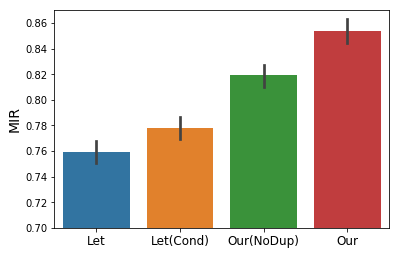

In [59]:
g=sns.barplot(odf.model, odf.MIR, order=['randomchar','random','no_dup','prob'])
g.set_ylim((0.7,0.87))
g.set_xticklabels(['Let','Let(Cond)','Our(NoDup)', 'Our'], fontsize=12, rotation=0)
g.set_xlabel('', fontsize=14)
g.set_ylabel(g.get_ylabel(), fontsize=14)
pl.savefig('./figs/redup_model_generator_eval_gold_test_mir.pdf',bbox_inches='tight')